# Assignment #3


Deep Learning / Spring 1398, Iran University of Science and Technology



---



**Please pay attention to these notes:**

<br/>
- **Assignment Due: ** 1398/02/20 23:59
- If you need any additional information, please review the assignment page on the course website.
- The items you need to answer are highlighted in red and the coding parts you need to implement are denoted by:
```
########################################
#     Put your implementation here     #
########################################
```
- We always recommend co-operation and discussion in groups for assignments. However, each student has to finish all the questions by him/herself. If our matching system identifies any sort of copying, you'll be responsible for consequences. So, please mention his/her name if you have a team-mate.
- Students who audit this course should submit their assignments like other students to be qualified for attending the rest of the sessions.
- Finding any sort of copying will zero down that assignment grade and also will be counted as two negative assignment for your final score.
- When you are ready to submit, please follow the instructions at the end of this notebook.
- If you have any questions about this assignment, feel free to drop us a line. You may also post your questions on the course's forum page.
- You must run this notebook on Google Colab platform; there are some dependencies to Google Colab VM for some of the libraries.
- **Before starting to work on the assignment please fill your name in the next section *AND Remember to RUN the cell.* **

<br/>


Assignment Page: [https://iust-deep-learning.github.io/972/assignments/03_cnn](https://iust-deep-learning.github.io/972/assignments/03_cnn)

Course Forum: [https://groups.google.com/forum/#!forum/dl972/](https://groups.google.com/forum/#!forum/dl972/)



---



Fill your information here & run the cell

In [0]:
#@title Enter your information & "RUN the cell!!"
student_id = 0 #@param {type:"integer"}
student_name = "" #@param {type:"string"}
Your_Github_account_Email = "" #@param {type:"string"}

print("your student id:", student_id)
print("your name:", student_name)


from pathlib import Path

ASSIGNMENT_PATH = Path('asg03')
ASSIGNMENT_PATH.mkdir(parents=True, exist_ok=True)

# 1. Batch Normalization

Training a deep neural network is a tricky process. Many techniques have already been proposed for more stable training and faster convergence. Most of these techniques either change the model architecture or improve the training algorithm. Batch normalization belongs to the former group. The method was introduced in 2015 and achieved state-of-the-art in ImageNet,  a well-known image classification benchmark.

## 1.1 Definition 

From the first assignment, you might remember that we generally normalize the inputs of a neural network to speed up the convergence. So if the "normalization" works, why not try it on the activation values? How can we improve training by normalizing the values of intermediate layers?

Here is an intermediate layer $l$ in some neural network:

<p align="center"><img src="https://iust-deep-learning.github.io/972/static_files/assignments/asg03_assets/01_intermediate_layer.jpg" width="500"/></p>




The general idea is to train layer $l$ faster by normalizing its input. By the layer $l$ we simply mean weigth matrices $W^{l}$, $b^{l}$ and by the input we mean previous layer's activations $a^{l-1}$. For the sake of simplicity, let us change our notation. Instead of normalizing the input of layer $l$, we would like to normalize the output so that the next layers will receive normalized values from our layer. It has the same effect, but it will make the equations much cleaner.

In practice, we do not normalize the output (the activations). Instead, we do the normalization on the weighted sum of inputs $Z^{l}$ just before applying the activation function ($Z^l = xW^l+b^l$).



## 1.2 The formula

Assume we want some variable $x$ to have normalized values, the only way to do that is to collect all of its values and calculate the mean and variance in order to create a normalized version of $x$. This is a fairly reasonable solution, and we use it to normalize the neural network's input. Now imagine the goal is to normalize some intermediate values in a deep neural network; Collecting values of some intermediate point in a neural network is almost impossible since the training algorithm can change them entirely. To overcome this issue, we can collect them over a mini-batch.  It will give us an estimated version of the mean and variance. This is why it is called Batch Normalization. Here is the detailed algorithm:

Given values of $x$ over a mini-batch $\mathcal{B} = \{x_1, .., x_m\}$ :

$$
\mu _\mathcal{B} = \frac{1}{m} \sum^{m}_{i=1} x_i  \ \ \ \ \ \text{(mini-batch mean)}
\\ 
\sigma^2 _\mathcal{B} = \frac{1}{m} \sum^{m}_{i=1} (x_i-\mu _\mathcal{B}) 
\ \ \ \ \ \text{(mini-batch variance)}
\\
x^{norm}_i = \frac{x_i - \mu _\mathcal{B}}{\sqrt{\sigma^2 _\mathcal{B} + \epsilon}} \ \ \ \ \ \text{(normalize)} 
\\ 
\hat{x}_i =\gamma x^{norm}_i+\beta  \ \ \ \ \ \text{(scale and shift)} 
\\
\mathrm{BN(\mathcal{B}, \gamma, \beta}) = \{\hat{x}_1, ..., \hat{x}_m\}
$$


**Notes:**
1. All of the notations above are non-vector.
2. $\gamma$ and $\beta$ are learnable parameters.
3. $\epsilon$ is just a small number, and we use it for numerical stability.
4. $\mathrm{BN}$ function calculates its output based on a batch of values. Consequently, we'll have different $\mu_\mathcal{B}$ and $\sigma^2_\mathcal{B}$ for each mini-batch during the training process. We will reference this property in the next sections.
5. $x^{norm}_i$ is actually the normalized version of $x_i$ which has mean 0 and variance 1. However, hidden units in neural networks have different distributions, and we don't really want them to all have the same distribution, So instead, we just scale and shift $x^{norm}_i$ with two variables $\gamma$, $\beta$. 
6. Another reason for the extra "scale & shift" step is that if we choose $\gamma = \sqrt{\sigma^2_\mathcal{B} + \epsilon}$ and $\beta = \mu_\mathcal{B}$ then $\hat{x}_i$ will become $x_i$, So the optimizer can easily remove the batch normalization if it is sufficient for proper training.

One difference between normalizing a neural network's inputs and Batch Normalization is that the latter does not force values to have mean 0 and variance 1. Explain it with at least one reason, why we might not want the hidden units to be forced to have mean 0 and variance 1.

$\color{red}{\text{Write your answer here}}$

### 1.2.2 Batch normalization at test time

As we said, We will have multiple $\mu_\mathcal{B}$ and $\sigma^2_\mathcal{B}$ since they are calculated individually for each mini-batch. So What should we do for the test time? In fact, the idea is quite simple; We can just calculate a moving average of $\mu_\mathcal{B}$ and $\sigma^2_\mathcal{B}$ to use at test time. Deep learning frameworks such as Tensorflow are using this algorithm in their default bach normalization implementations.

## 1.3 Applying the batch-norm on layers

Batch Normalization (or simply batch-norm) doesn't know anything about the concept of layers and vectors. we have to integrate it manually in our layers. For a given d-dimensional vector of logits $Z = (z^{(1)},..., z^{(d)})$, the batch-normalized version is 

$$
Z = (\ \mathrm{BN}(\mathcal{B}\{z^{(1)}\}, \gamma^{(1)}, \beta^{(1)}),..., \mathrm{BN}(\mathcal{B}\{z^{(d)}\}, \gamma^{(d)}, \beta^{(d)})\ )
$$

As you might have noticed, we need a batch for each $Z$'s element in the latter version. In other words, we need a batch of $Z$. Fortunately, this is good news for us since we build our neural networks entirely based on batches.

Write the vectorized version of batch-norm equations and specify the dimensions.

For any given layer $l$ with $n$ hidden units and batch size $b$:

$$
z = xW + B\ \ \ \  z \in \mathbb{R} ^ {b \times n}, W \in \mathbb{R} ^ {m \times n}, B \in \mathbb{R} ^ {b \times n}, x \in \mathbb{R} ^ {b \times m}
$$


$$
\mu = \color{red}{\text{Write your answer here}}
$$

$$
\sigma^2 = \color{red}{\text{Write your answer here}}
$$

$$
z^{norm} = \color{red}{\text{Write your answer here}}
$$

$$
\hat{z} = \gamma \odot z^{norm} + \beta  \ \ \ \ \ \ (\odot \text{ is an element-wise dot product} )
$$

Write dimensions for $\mu$, $\sigma^2$, $z^{norm}$, $\gamma$, $\beta$, and any intermediate variable you've defined:

$\color{red}{\text{Write your answer here}}$

Imagine a simple neural network with l hidden layers. We want to apply the batch-norm on all layers. Here is how it would look ($\mathcal{X}^{b} $ is an input batch):

$$
\mathcal{X}^{b}\stackrel{W^{[1]}, B^{[1]}}{\longrightarrow}Z^{[1]} \stackrel{\gamma^{[1]}, \beta^{[1]}}{\longrightarrow}\hat{Z}^{[1]} \longrightarrow a^{[1]} = func^{[1]}(\hat{Z}^{[1]})\stackrel{W^{[2]}, B^{[2]}}{\longrightarrow} ...
$$

Also, the parameters for that neural network would be:
$$
W^{[1]}, B^{[1]} \ \  \ \ W^{[2]}, B^{[2]}  \ \ ... \ \ W^{[l]}, B^{[l]} 
\\
\gamma^{[1]}, \beta^{[1]} \ \ \ \  \  \ \ \gamma^{[2]}, \beta^{[2]}  \ \ \ \  ... \ \ \ \ \gamma^{[l]}, \beta^{[l]} 
$$

$B^{[i]}$ is the bias term in our neural, but with incorporating the batch-norm and introduction of new variables, $B^{[i]}$ will become unnecessary. Prove that why.

$\color{red}{\text{Write your answer here}}$

## 1.4 Why does it work?

Imagine a super simple neural network:

<br/>
<p align="center"><img src="https://iust-deep-learning.github.io/972/static_files/assignments/asg03_assets/02_simple_nn.png" width="300"/>
<br>
  [[source](https://blog.paperspace.com/busting-the-myths-about-batch-normalization/)]
</p>

</br>
During the training, Our optimizer calculates the gradients with respect to weights. Take layer **a** as an example; Optimizer calucates  $\frac{\partial L}{\partial a}$ and then it updates the weights for this layer. Unfortunately,  it means that weight update for Layer **a** only depends on the sensitivity of loss function to that weight. However, changing weights of initial layers can completely effect the statistics of any futher layer.

With the presence of Batch Normalization, our optimizer package can now adjust two parameters $\gamma$, $\beta$ to change statistics of any layer, rather than entire weight matrix. It makes the training of any layer independent and also introduces some checkpointing mechanism.

Besides, recent findings show that batch normalization smoothes the landscape/surface of the loss function, effectively making the optimization performance less dependant on the initial state.

<p align="center"><img src="https://iust-deep-learning.github.io/972/static_files/assignments/asg03_assets/03_error_surface.jpg"  width="700"/>
<br/>
  source: [2]
  </p>

## 1.5 Batch Normalization in action


Now let's create a layer to use batch normalization easier.

In [0]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Layer, Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical

In [0]:
class BatchNormalizedLayer(Layer):
  def __init__(self, layer, axis=-1, activation=None, **kwargs):
    """Runs batch normalization on layer instance and applies the activation function
    
    Args:
      layer(layers.Layer): A layer to normalize its output
      axis(int): the axis that should be normalized (typically the features axis).
      activation(str): Activation function to use
    """
    super(BatchNormalizedLayer, self).__init__(**kwargs)
    
    self.layer = layer
    self.activation = activation
    self.axis = axis
    
  def call(self, inputs):
    """Runs the layer
    
    Args:
      inputs: The layer's input
      
    hint: keras.layers.normalization.BatchNormalization and layers.Activation might be useful for you
    """
    ########################################
    #     Put your implementation here     #
    ########################################

In [0]:
import numpy as np

bnl = BatchNormalizedLayer(Dense(5), activation='relu')
x = K.constant(2.5 * np.random.randn(10, 4) + 3)

assert K.eval(bnl(x)).shape == (10, 5)

### 1.5.1 CNN

Now we have our special layer. So, let's use it in a real neural network. We want to improve the baseline using the Batch Normalization layer. Our desired task is CIFAR10 image  classification. 

First, let's load the dataset:

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import cifar10

num_classes = 10

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Visualizing CIFAR 10
fig, axes1 = plt.subplots(2,5,figsize=(10,4))
for j in range(2):
  for k in range(5):
    i = np.random.choice(range(len(x_train)))
    axes1[j][k].set_axis_off()
    axes1[j][k].imshow(x_train[i:i+1][0])
        
# Normalize
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
def visualize_loss_and_acc(history):
  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  acc = history_dict['acc']

  epochs = range(1, len(acc) + 1)

  f = plt.figure(figsize=(10,3))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss_values, 'bo', label='Training loss')
  plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()


  acc_values = history_dict['acc']
  val_acc = history_dict['val_acc']

  plt.subplot(1,2,2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

#### Baseline

Define the baseline model

In [0]:
def get_baseline_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
  
  model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.rmsprop(lr=0.0001, decay=1e-6),
                metrics=['accuracy'])
  
  return model

Train the baseline

In [0]:
batch_size = 32
epochs = 25

In [0]:
# Create the baseline model
baseline = get_baseline_model()

# Train model
bs_history = baseline.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    shuffle=True
)

Visualize the training and evaluate the model

In [0]:
visualize_loss_and_acc(bs_history)

In [0]:
# Score trained model.
scores = baseline.evaluate(x_test, y_test, verbose=1)
print('Test accuracy:', scores[1])

#### Improved

Now update the baseline to create an enhanced model only by using `BatchNormalizedLayer` 

In [0]:
def get_improved_model():
  
  model = Sequential()
  
  ########################################
  #     Put your implementation here     #
  ########################################
  
  # model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
  # model.add(Activation('relu'))
  # model.add(Conv2D(32, (3, 3)))
  # model.add(Activation('relu'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  # model.add(Dropout(0.25))

  # model.add(Conv2D(64, (3, 3), padding='same'))
  # model.add(Activation('relu'))
  # model.add(Conv2D(64, (3, 3)))
  # model.add(Activation('relu'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  # model.add(Dropout(0.25))

  # model.add(Flatten())
  # model.add(Dense(512))
  # model.add(Activation('relu'))
  # model.add(Dropout(0.5))
  # model.add(Dense(num_classes))
  # model.add(Activation('softmax'))
  
  model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.rmsprop(lr=0.0001, decay=1e-6),
                metrics=['accuracy'])
  
  return model

Train and evaluate

In [0]:
# Create the baseline model
impv_model = get_improved_model()

# Train model
impv_history = impv_model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    shuffle=True
)

Visualize the training and evaluate the model

In [0]:
visualize_loss_and_acc(impv_history)

In [0]:
# Score trained model.
scores = impv_model.evaluate(x_test, y_test, verbose=1)
print('Test accuracy:', scores[1])

In [0]:
# Remember to run this cell after each time you update the model, 
# this is a deliverable item of your assignemnt
impv_model.save(str(ASSIGNMENT_PATH / 'cifar_impv.h5'))

**Question:** Compare your model to the baseline. What are the diffrences? Does batch normalization work?

$\color{red}{\text{Write your answer here}}$

# 2. Denoising


In this part, we are going to implement a simple denoising network. The purpose of this assignment is to help you become familiar with autoencoders and Conv2DTranspose (known as deconvolution layer) and UpSampling2D layers in keras.



##2.1 Problem Definition

We have a noisy version of mnist data. The goal in this assignment is to remove the noise using an autoencoder neural network.

#### Autoencoder:
An autoencoder neural network has the following architecture:

<p align="center"><img src="https://iust-deep-learning.github.io/972/static_files/assignments/asg03_assets/06_autoencoder_structure.png" width="500"/>  
  [[source](https://en.wikipedia.org/wiki/Autoencoder)]
</p>



The encoder part usually takes the input (X) and makes a more dense representation of it (z) and the decoder part tries to make the output (X') from the coded representation. Since the network itself learns how to encode the input data into some meaningful feature representation,  we call this network an "autoencoder"'.


#### Denoising Using Autoencoders:

Autoencoders have a wide varity of usages. One usage is to reduce the noise in an input image.
Suppose we train an autoencoder by feeding some noisy images as inputs and having the noise-free version of those images as desired outputs. This way the encoder part learns to extract the most important features of the input image and the decoder part learns to reconstruct noise-free images from extracted features. 

##2.2 Solving The Problem

#### Preparing Mnist Data:

Lets prepare our data

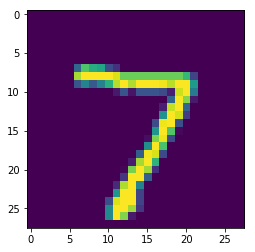

In [0]:
import matplotlib.pyplot as plt
from keras.datasets import mnist

# We don't really need the classification lables, just images
(real_images_train, _ ), (real_images_test, _ ) = mnist.load_data()
# Normalizing values to be between 0 and 1
real_images_train = real_images_train / 255.0
real_images_test = real_images_test / 255.0

plt.imshow (real_images_test[0])
plt.show()

Lets add some noise to our train and test sets

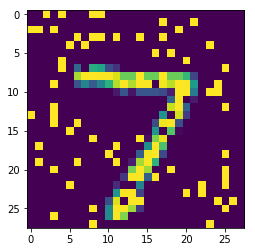

In [0]:
import numpy as np

noise = np.random.random((60000, 28, 28))
noisy_images_train = np.copy(real_images_train)
noisy_images_train[np.where(noise>0.9)] = 1.0
noisy_images_train[np.where(noise<0.1)] = 0.0

noise = np.random.random((10000, 28, 28))
noisy_images_test = np.copy(real_images_test)
noisy_images_test[np.where(noise>0.9)] = 1.0
noisy_images_test[np.where(noise<0.1)] = 0.0

plt.imshow(noisy_images_test[0])
plt.show()

And finally reshape our data sets in order to be compatible with keras layers

In [0]:
input_train = noisy_images_train.reshape((60000, 28, 28, 1))
output_train = real_images_train.reshape((60000, 28, 28, 1))

input_test = noisy_images_test.reshape((10000, 28, 28, 1))
output_test = real_images_test.reshape((10000, 28, 28, 1))

#### Creating the model:

We build the encoder part using some convolution and pooling layers:

In [0]:
from keras.layers import Conv2D, MaxPooling2D

def encoder (input_layer):
  x = Conv2D(16, (3, 3), activation='relu')(input_layer)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(8, (2, 2), activation='relu')(x)
  x = MaxPooling2D((2, 2))(x)
  encoded = Conv2D(8, (3, 3), activation='relu')(x)
  return encoded

As you know, passing an input of size (x, y) to a convolution layer with filter size (h, h), stride equal to one and no padding, results in a  (x+1-h, y+1-h) sized output feature map, and also we know each polling layer with filter size (r, r) will reduce both the heigh and width of the input by a factor of *r*.
So if we assume that input size is 28 by 28 (mnist image size), the output of this encoder will be 8 feature maps and each of theme is in size of 4 by 4 (the output shape will be  (4, 4, 8) )

Now we want to build the decoder part using a stack of *Conv2DTranspose* and *UpSampling2D* layers.

So **why do we need upsampling in the first place?**  When we use neural networks to generate images, it usually involves up-sampling from low resolution to high resolution, as in this example, we need to reconstruct 28x28 pictures from extracted featur maps.

There are various methods to conduct up-sampling operation, the first and the most simple method is to use  upsampling layers. An upsampling layer simply increases the size of input image using known interpolation methods (such as bi-linear or bi-cubic).

Another way is using a convolution transpose layer (or known as deconvolution layer). In a normal convolution operation, we calculate the sum of the element-wise multiplication between the input matrix and kernel matrix. More concretely, the $h* h$ kernel is used to connect the $h^2$ values in the input matrix to $1$ value in the output matrix. A convolution operation forms a **many-to-one** relationship. On the other hand, a deconvolution operation is a  **one-to-many** operaion.

As an example by using a convolution layer with kernel size (3, 3) on an image with size (4, 4), we get an image of size (2, 2). We can reverse this process and simply use a convolution transpose layer with kernel size (3, 3) on top of an image with size (2, 2) to get an upsampled version by size (4, 4). See the following picture for a better understanding:

<p align="center"><img src="https://iust-deep-learning.github.io/972/static_files/assignments/asg03_assets/07_deconv.jpg
" width="800"/></p>

<br>

Using convolution transpose layer can have side effects, one of them is known as **checkerboard artifacts**. Read about this side effect and explain why do you think it happens?


$\color{red}{\text{Write your answer here}}$

So, what is the difference between upsampling and convolution transpose layers? The answer is that the upsampling layer has no parameters to learn and simply does some mathematical operations on the input image in order to make higher resolution images, but a convolution transpose layer uses a trainable kernel to upsample the input.

Now, using these layers we can build our decoder. Read the full documentation of these two layers, and use the right size for each layer in order to make a 28 by 28 output:


In [0]:
from keras.layers import Conv2DTranspose, UpSampling2D

def decoder (input_layer):
  
  ##########################################
  # fill the ? marks with appropriate size #
  ##########################################
  
  x = Conv2DTranspose(8, (?, ?), activation='relu')(input_layer) 
  x = UpSampling2D((?, ?))(x)
  x = Conv2DTranspose(8, (?, ?), activation='relu')(x)
  x = UpSampling2D((?, ?))(x)
  decoded = Conv2DTranspose(1, (?, ?), activation='relu')(x)
  return decoded

Putting parts together:

In [0]:
from keras.layers import Input
from keras.models import Model

input_layer = Input(shape=(28, 28, 1))
features = encoder (input_layer)
output_layer = decoder (features)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

####Training The Model####

In [0]:
autoencoder.fit(input_train, output_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(input_test[:500], output_test[:500]))

####Testing The Result 

In [0]:
decoded_imgs = autoencoder.predict(input_test)

n_to_visualize = 20
plt.figure(figsize=(20, 4))
for i in range(1, n_to_visualize+1):
    # display original
    ax = plt.subplot(2, n_to_visualize, i)
    plt.imshow(input_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n_to_visualize, i + n_to_visualize)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
# Don't forget to run this cell.
# this is a deliverable item of your assignemnt
autoencoder.save(str(ASSIGNMENT_PATH / 'denoising_autoenc.h5'))

# 3. Semantic segmentation

<img src="https://iust-deep-learning.github.io/972/static_files/assignments/asg03_assets/04_img_seg.jpg"  width=500 />

[source](https://medium.com/nanonets/how-to-do-image-segmentation-using-deep-learning-c673cc5862ef)

Semantic segmentation is one of the high-level computer vision tasks that helps the machins to understand a scene. In the semantic segmentation task, we aim to label an image at pixel level, so that we can detect the boundaries of an object in the picture. This task has many applications in the area of self-driving vehicles, human-computer interaction, virtual reality, etc.


For example, if you have to explainthe up right image in the following picture, how you are going to do it? Is the following sentence is a good answer?

**"Two men riding on a bike in front of a building on the road. And there is a car."**

<img src="https://iust-deep-learning.github.io/972/static_files/assignments/asg03_assets/05_img_seg_02.png" width=500>

[source](http://www.cs.toronto.edu/~tingwuwang/semantic_segmentation.pdf)

How a machine can generate such an information about the image? To generate such an explanation about a scene a machine should be able to detect different objects and their boundaries in the image.


**How to do semantic segmentation?**

Semantic segmentation divides into to steps:


1.   encode the input image to extract features
2.   decode the extracted features into a higher resolousion picture

Usualy for the first step, we use a pretrained network to extract features, and then, use the output of that network to generate the higher resolousion image.

The most common loss function for this task is a pixel-wise cross entropy loss. This loss examines each pixel individually.

---



In this assignment, we want to implement a convolutional deep neural network that detects horses and dogs in an image and shows us boundaries of object in the picture. 

we are going to use the HorseSeg and DogSeg datasets. According to the [Alexander Kolesnikov's web page](http://pub.ist.ac.at/~akolesnikov/HDSeg/): 
 
     "HorseSeg and DogSeg are two semantic image segmentation datasets with 25,679 and 158,984 images respectively. The images for these datasets were collected from the ImageNet dataset and PASCAL VOC12. Images from PASCAL VOC12 have manually created annotations. Images from the ImageNet dataset dataset have weak supervision which is per-image labels and approximatelly one quater of all images also have object bounding boxes."
     
First of all, you should choose one of the datasets. You can either choose the HorseSeg or the DogSeg. In the following box write down the dataset you have chosen.

$\color{red}{\text{Write your answer here}}$


After that, you need to download the training set and annotations. 
1.  You can download the annotations from [here](http://pub.ist.ac.at/~akolesnikov/HDSeg/HDSeg.tar).
2.   There is a script in the dowloaded file which you should run to download the dataset. Run it as we did in the following code box.
3.   When you run the code, it will ask you for your image-net username and access key. You can use your academic email to obtain a username and access key to the image-net at the [image-net.org](http://www.image-net.org/)
4.   If you could not obtain your access key you can use the other file which we have uploaded on the course webpage.

In [0]:
# Download the dataset and its labels
! wget http://pub.ist.ac.at/~akolesnikov/HDSeg/HDSeg.tar

! wget https://iust-deep-learning.github.io/972/static_files/assignments/asg03_assets/download_imagenet.sh
! bash download_imagenet.sh HorseSeg
! bash download_imagenet.sh DogSeg

Use the following code to load the data into the runtime machine. Shape of each images in this dataset is different, but we convert all of them to a 256x256.

In [0]:
import os
import numpy as np
from keras.preprocessing import image


def retrieve_file_names(dataset_name):
    if dataset_name not in ['HorseSeg', 'DogSeg']:
      print('dataset name is not valid')
      return None
    path = 'images/%s' % dataset_name
    files_path = []
    dirs= os.listdir(path)
    for d in dirs:
      inner_path = path + '/' + d
      files = os.listdir(inner_path)
      for file in files:
        files_path.append(inner_path + '/' + file)
    return files_path

def load_data(dataset_name):
    if dataset_name not in ['HorseSeg', 'DogSeg']:
      print('dataset name is not valid')
      return None, None
    files_path = retrieve_file_names(dataset_name)
    print(files_path)
    dataset = []
    dataset_y = []
    for path in files_path:
      img = image.load_img(path, target_size=(256, 256))
      x = image.img_to_array(img)
      dataset.append(x)
      img_path = path
      img_path = img_path.replace("images", "annotations")
      img = image.load_img(img_path, target_size=(256, 256))
      x = image.img_to_array(img)
      dataset_y.append(x)
    dataset = np.array(dataset)
    dataset_y = np.array(dataset_y)

    nb_sample = dataset.shape[0]
    split = int(nb_sample * 0.75)
    training, training_y, test, test_y = dataset[:split,:], dataset_y[:split,:], dataset[split:,:], dataset_y[split:,:]
    return training, test

training, training_y, test, test_y = load_data('HorseSeg')


**Use a pre-trained network**

Keras provides a set of pre-trained networks, use this [link](https://keras.io/applications/) and take a look at them. In this assignment, we want to use VGG19 network for segmentation.

As you see in the following code box, we imported the ResNet50 network.

In [0]:
from keras.applications.resnet50 import ResNet50

model = ResNet50(weights='imagenet', include_top=False)
print(model.summary())


In the following code box, implement a code that loads the 'block5_conv2' layer of the VGG19 network , and in the next one load the 'fc2' layer of the network.

In [0]:
########################################
#     Put your implementation here     #
########################################

In [0]:
########################################
#     Put your implementation here     #
########################################

Use a stack of the [deconvolution layers](https://keras.io/layers/convolutional/#conv2dtranspose) and other types of layers that you have learned to implement the encoder part of this network. 

1.   In the following code box, implement your encoder.
2.   In the next two code boxes, attach the encoder to the decoders, and then, train the networks.

In [0]:
########################################
#     Put your implementation here     #
########################################

In [0]:
########################################
#     Put your implementation here     #
########################################

In [0]:
########################################
#     Put your implementation here     #
########################################

Now, it is time to evaluate your network. Write the testing process in the following box. You should use the testset that you have loaded before to evaluate your network.

**Note:** you should report accuracy and loss for training set, validation set, and test set. You should also demonstrate 10 input image and the regions that were predicted to be horse or dog.

In [0]:
########################################
#     Put your implementation here     #
########################################

**Optional:**

This part is optional and you can ignore it if you are not interested in it. But, if you are interested, you can implement one more network and get extra score.

In this part you should implement both parts of the network by yourself, without using any pretrained network. Note that this network should be trained on both of the datasets. The output of this network for horses and dogs must be different. For example, it should mark the regions that it sees a dog with blue, the regions that it sees a horse with red, and other regions with black.

**Note:** copying a code from github will result a negative  score for this part.

In [0]:
########################################
#     Put your implementation here     #
########################################

# Submission

Congratulations! You finished the assignment & you're ready to submit your work. Please follow the instruction:

1. Check and review your answers. Make sure all of the cell outputs are what you want. 
2. Select File > Save.
3. Run **Create Submission** cell, It may take several minutes and it may ask you for your credential.
4. Run **Download Submission** cell to obtain your submission as a zip file.
5. Grab downloaded file (`dl_asg03__xx__xx.zip`) and submit it via https://forms.gle/WEAHLkhvUAHTyYux6.

**Note: ** We need your Github token to create a new repository  (if it doesn't exist previously) in order to store learned model data. Also Google Drive token enables us to download the current notebook and Create the submission. If you are interested, feel free to check our code.

## Create Submission (Run the cell)

In [0]:
#@title
! pip install -U --quiet PyDrive > /dev/null
! wget -q https://github.com/github/hub/releases/download/v2.10.0/hub-linux-amd64-2.10.0.tgz 
  
import os
import time
import yaml
import json

from google.colab import files
from IPython.display import Javascript
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

asg_name = 'assignment_03'
script_save = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
repo_name = 'iust-deep-learning-assignments'
submission_file_name = 'dl_asg03__%s__%s.zip'%(student_id, student_name.lower().replace(' ',  '_'))
course_url = 'https://iust-deep-learning.github.io/972/'

! tar xf hub-linux-amd64-2.10.0.tgz
! cd hub-linux-amd64-2.10.0/ && chmod a+x install && ./install
! hub config --global hub.protocol https
! hub config --global user.email "$Your_Github_account_Email"
! hub config --global user.name "$student_name"
! hub api -X GET /user
! hub api -X GET /user > user_info.json
! hub api -F affiliation=owner -X GET /user/repos > repos.json

user_info = json.load(open('user_info.json'))
repos = json.load(open('repos.json'))
repo_names = [r['name'] for r in repos]
has_repository = repo_name in repo_names
if not has_repository:
  get_ipython().system_raw('! hub api -X POST -F name=%s /user/repos homepage="%s" > repo_info.json' % (repo_name, course_url))
  repo_info = json.load(open('repo_info.json')) 
  repo_url = repo_info['clone_url']
else:
  username = user_info['login']
  ! hub api -F homepage="$course_url" -X PATCH /repos/$username/$repo_name
  for r in repos:
    if r['name'] == repo_name:
      repo_url = r['clone_url']
  
stream = open("/root/.config/hub", "r")
token = list(yaml.load_all(stream))[0]['github.com'][0]['oauth_token']
repo_url_with_token = 'https://'+token+"@" +repo_url.split('https://')[1]

! git clone "$repo_url_with_token"
! cp -r "$ASSIGNMENT_PATH" "$repo_name"/
! cd "$repo_name" && git add -A
! cd "$repo_name" && git commit -m "Add assignment 02 results"
! cd "$repo_name" && git push -u origin master

sub_info = {
    'student_id': student_id,
    'student_name': student_name, 
    'repo_url': repo_url,
    'asg_dir_contents': os.listdir(str(ASSIGNMENT_PATH)),
    'datetime': str(time.time()),
    'asg_name': asg_name
}
json.dump(sub_info, open('info.json', 'w'))

Javascript(script_save)

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = drive.ListFile({'q':"title='%s.ipynb'"%asg_name}).GetList()[0]['id']
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('%s.ipynb'%asg_name) 

! jupyter nbconvert --to script "$asg_name".ipynb > /dev/null
! jupyter nbconvert --to html "$asg_name".ipynb > /dev/null
! zip "$submission_file_name" "$asg_name".ipynb "$asg_name".html "$asg_name".txt info.json > /dev/null

print("##########################################")
print("Done! Submisson created, Please download using the bellow cell!")

## Download Submission (Run the cell)

In [0]:
#@title
files.download(submission_file_name)

# References



1. Ioffe, Sergey, and Christian Szegedy. “Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift.” ArXiv:1502.03167 [Cs], February 10, 2015. http://arxiv.org/abs/1502.03167.
* Im, Daniel Jiwoong, Michael Tao, and Kristin Branson. “An Empirical Analysis of the Optimization of Deep Network Loss Surfaces.” ArXiv:1612.04010 [Cs], December 12, 2016. http://arxiv.org/abs/1612.04010.
* Santurkar, Shibani, Dimitris Tsipras, Andrew Ilyas, and Aleksander Madry. “How Does Batch Normalization Help Optimization?” In Advances in Neural Information Processing Systems 31, edited by S. Bengio, H. Wallach, H. Larochelle, K. Grauman, N. Cesa-Bianchi, and R. Garnett, 2483–2493. Curran Associates, Inc., 2018. http://papers.nips.cc/paper/7515-how-does-batch-normalization-help-optimization.pdf.
* Coursera Course: Improving Deep Neural Networks: Hyperparameter tuning, Regularization and Optimization
* Intro to optimization in deep learning: Busting the myth about batch normalization [[link](https://blog.paperspace.com/busting-the-myths-about-batch-normalization/)]
* Why Does Batch Normalization Work? [[link](https://abay.tech/blog/2018/07/01/why-does-batch-normalization-work/)]
*  http://www.cs.toronto.edu/~tingwuwang/semantic_segmentation.pdf
*  https://medium.com/nanonets/how-to-do-image-segmentation-using-deep-learning-c673cc5862ef
* https://www.jeremyjordan.me/semantic-segmentation/

